# Combine mice to simulate a large recorded population

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add local scripts to path
import os,sys
sys.path.insert(0,os.path.abspath("./"))
import neurotools

# Set up cache
from neurotools.jobs.initialize_system_cache import initialize_caches,cache_test
PYCACHEDIR = os.path.abspath('./')
CACHENAME  = 'PPC_cache'
from neurotools.tools import ensure_dir
ensure_dir(PYCACHEDIR+os.sep+CACHENAME)
initialize_caches(
    level1  = PYCACHEDIR,
    force   = False,
    verbose = False,
    CACHE_IDENTIFIER = CACHENAME)

# Import libraries
from neurotools.nlab import *
import ppc_data_loader

# Set this to the location of the PPC data on your machine
ppc_data_loader.path = '/home/mer49/Dropbox (Cambridge University)/Datasets/PPC_data/'
from ppc_data_loader   import *
from ppc_trial         import *

# Configure Numpy
np.set_printoptions(precision=3)
import warnings
warnings.filterwarnings("ignore","scipy")
np.seterr(all='ignore')
np.set_printoptions(precision=2)
print('numpy configured')

# Configure Matplotlib
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
TEXTWIDTH = 5.62708
FIGWIDTH,FIGHEIGHT = TEXTWIDTH, TEXTWIDTH/sqrt(2)
matplotlib.rcParams['figure.figsize'] = (FIGWIDTH,FIGHEIGHT)
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore",category=MatplotlibDeprecationWarning)
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
matplotlib.rc('font' , size   =SMALL_SIZE ) # controls default text sizes
matplotlib.rc('axes' , titlesize=MEDIUM_SIZE) # fontsize of the axes title
matplotlib.rc('axes' , labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
matplotlib.rc('xtick' , labelsize=SMALL_SIZE ) # fontsize of the tick labels
matplotlib.rc('ytick' , labelsize=SMALL_SIZE ) # fontsize of the tick labels
matplotlib.rc('legend', fontsize =SMALL_SIZE ) # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
matplotlib.rc('lines' , solid_capstyle='round')
matplotlib.rcParams['image.cmap'] = 'parula'
from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color=[BLACK,RUST,TURQUOISE,OCHRE,AZURE,MAUVE,MOSS,INDEGO,VIOLET,VERIDIAN,CRIMSON])
matplotlib.rc('savefig',dpi=240) 
print('Matplotlib configured')

import pickle
np.random.seed(0)

Data location is /home/mer49/Workspace2/PPC_data/
numpy configured
Matplotlib configured


# Find neurons 

We will merge these into a single virtual mouse. 

In [2]:
unitmap = {}
for animal in get_subject_ids():
    print('Mouse %d'%animal)
    unitmap[animal] = get_unit_availability_map_by_days(animal)

Mouse 1
Mouse 2
Mouse 3
Mouse 4
Mouse 5


## Register sessions ↔ days

In [3]:
session_to_day = {}
day_to_session = {}
for animal in get_subject_ids():
    sessions = int32(get_session_ids(animal))
    s = sessions[0]
    hdfdata = get_data(animal,s)
    Δd = int32(getHDF(hdfdata,'session_obj/deltaDays'))
    hdfdata.close()
    for s in sessions:
        d = Δd[s-1]
        session_to_day[animal,s] = d
        day_to_session[animal,d] = s

## Gather units with spans of sessions with no more than a 2 day gap

In [4]:
MINDAYS = 6
MAXSKIP = 3

def get_ok_spans(days_present,MAXSKIP=2,MINDAYS=9):
    spans   = []
    span    = []
    missing = 0
    for d,b in enumerate(days_present):
        if b:
            span.append(d)
            missing = 0
        elif missing<=MAXSKIP:
            missing += 1
            if missing>MAXSKIP:
                spans.append(span)
                span = []
    return [s for s in spans if len(s)>=MINDAYS]

use_units = []
for animal,units in unitmap.items():
    for iunit,unit in enumerate(units.T):
        spans = get_ok_spans(unit,MAXSKIP,MINDAYS)
        if len(spans)>0:
            span = spans[0] # Only use each neuron once
            sessions = [day_to_session[animal,d+1] for d in span]
            use_units.append((animal,iunit,sessions[:MINDAYS]))

print('%d units identified'%len(use_units))

1238 units identified


## Get Pseudotime-aligned activity for each unit

Each unit has an associated range of sessions. For each unit and session, get all (valid) trials from that session. Separate trials into groups with matching cue and previous-trial cue. 

In [5]:
def get_ok_spans(days_present,MAXSKIP=2,MINDAYS=9):
    spans   = []
    span    = []
    missing = 0
    for d,b in enumerate(days_present):
        if b:
            span.append(d)
            missing = 0
        elif missing<=MAXSKIP:
            missing += 1
            if missing>MAXSKIP:
                spans.append(span)
                span = []
    return [s for s in spans if len(s)>=MINDAYS]
    
@memoize
def get_all_long_term_neurons(MAXSKIP=2,MINDAYS=9):
    use_units = []
    for animal,units in unitmap.items():
        for iunit,unit in enumerate(units.T):
            spans = get_ok_spans(unit,MAXSKIP,MINDAYS)
            if len(spans)>0:
                span = spans[0] # Only use each neuron once
                sessions = [day_to_session[animal,d+1] for d in span]
                use_units.append((animal,iunit,sessions[:MINDAYS]))
    return use_units

@memoize
def get_pseudotime_aligned_by_trial_type(a,s,ui,
                                         TIMERES=100,
                                         JITTER =25):
    """
    We need to know about the trial structure for every unit
    Matched trials based on cue and previous cue
    This takes a while to compute, so save results on disk for later. 
    """
    # Align neural data to pseudotime
    at = align_trials(a,[s],[get_dFF(a,s,[ui]).T],
                      PSTIMERES=TIMERES,
                      JITTER   =JITTER)[0].squeeze()
    # Group by trial type
    trials = array(get_trials_with_context(a,s,JITTER=JITTER))
    types  = int32([t.previous.cue*2+t.cue for t in trials])
    snips  = [at[find(types==ty)] for ty in range(4)]
    return snips

@memoize
def get_trial_aligned_long_term_neurons(MAXSKIP=2,MINDAYS=9):
    units = get_all_long_term_neurons(MAXSKIP=MAXSKIP,MINDAYS=MINDAYS)
    
    # Run in parallel since this is time-consuming
    # Shuffle jobs to reduce the number of threads accessing each file
    # (this seems to cause problems on some systems)
    # Set debug=True to disbable parallelism if problem arise
    jobs    = [(a,s,ui,100,25) for a,ui,ss in units for s in ss]
    np.random.shuffle(jobs)
    print('Converting to trial pseudotime')
    results = parimap(get_pseudotime_aligned_by_trial_type,jobs,debug=False)
    
    # Results are in no particular order, since we shuffled the jobs
    # However, all results are now cached, so we can go back and read
    # them in order.
    # Extract Calcium signals for each unit,session,trial type
    all_snips = []
    for a,ui,ss in progress_bar(units): 
        unit_snips = []
        for s in ss:
            unit_snips.append(get_pseudotime_aligned_by_trial_type(a,s,ui))
        all_snips.append(unit_snips)

    # For every unit, we have a list of sessions, which each have a 
    # list of trials of each type. We'd like to merge all these 
    # together. First, we need to treat each session separately. So, 
    # re-organize the data into sessions. Then, every unit will have 
    # four lists, each list containing the available trials. We want to 
    # "zip" each of these lists across units. Then, we merge these in 
    # (approximate) temporal order.
    trialdata = []
    for si in range(MINDAYS):
        s = array([u[si] for u in all_snips]).T
        z = array([array(list(zip(*x))) for x in s])
        k = [(i,j) for i in range(4) for j in range(len(z[i]))]
        l = [r for x in z 
             for r in linspace(0,1,x.shape[0])+rand()/x.shape[0]]
        x = array([z[i][j].T for (i,j) in array(k)[argsort(l)]])
        trialdata.append(x)
    return trialdata

trialdata = get_trial_aligned_long_term_neurons(MAXSKIP,MINDAYS)

## Test decoding

97.40% variance explained


Text(0, 0.5, 'Decoded task phase (%)')

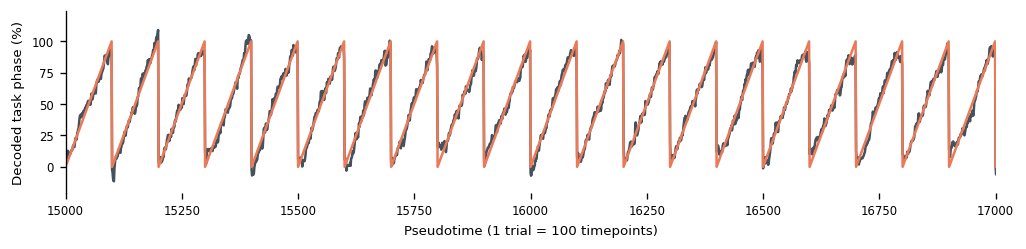

In [6]:
zeromeaned = array([zeromean(x,axis=1) for x in trialdata])
ols_trainz = cat(zeromeaned)
Ntrials, Ntimes, Nneurons = ols_trainz.shape
ols_trainx = ones(Ntrials)[:,None]*linspace(-1,1,Ntimes)[None,:]
ols_trainz = ols_trainz.reshape((Ntrials*Ntimes,Nneurons))
ols_trainx = ols_trainx.reshape((Ntrials*Ntimes,1))
ols_w,ols_xhat,_,ols_rms = crossvalidated_least_squares(ols_trainz,ols_trainx,10)
print('%4.2f%% variance explained'%((1-(ols_rms/std(ols_trainx))**2)*100))

figure(figsize=(10,2))
plot(100*(ols_xhat*0.5+0.5),label='Esimated')
plot(100*(ols_trainx*0.5+0.5),label='True')
simpleraxis()
xlim(15000,15000+2000)
xlabel('Pseudotime (1 trial = 100 timepoints)')
ylabel('Decoded task phase (%)')

## Test LMS

In [7]:
def run_LMS(X,Y,w0=None,rate=1,reg=1e-12,normalized=False,delta=None,clip=None):
    '''
    Run the LMS algorithm 
    s
    Parameters
    ----------
    X: array-like; Nsamples x Nfeatures
        Independent (input) variables
    Y: array-like; Nsamples x Noutputs
        Dependent (output) variables
    
    Other Parameters
    ----------------
    w0: array-like
        Initial parameter weighers
    rate: scalar, default 1
        Learning rate
    reg: scalar, default 1e-12
        L2 regularization penalty to shrink weight
    normalized: bool, default True
        Whether to run the Normalized LMS
    delta: positive scalar, default is None
        (This is not used in the paper.)
        If not `None`, we will report not the true weights
        but the a process that tracks the true rates, with 
        a limit of `delta` change/timestep. In theory,
        this would correspond to a slow process (e.g. 
        synaptic size change), while the actual fast changes
        in synaptic strength are handled by some other 
        process.
    clip: positive scalar, default is None
        If not `None`, then weight changes will be limited
        to be no larger than this value (up to floating point
        accuracy). This is important for enforcing an upper
        bound on the rate of weight change. 

    Returns
    -------
    all_w:
        Weights over time
    all_e;
        Errors over time
    all_yh:
        Predicted kinematics over time
    '''
    X = np.array(X)
    Y = np.array(Y)
    if len(Y.shape)==1:
        Y = array([Y]).T
    rate  = np.float32(rate)
    if not delta is None:
        delta = np.abs(np.float32(delta))
    if not clip  is None:
        clip  = np.abs(np.float32(clip))
    Nsamples   = Y.shape[0]
    Nfeatures  = X.shape[1]
    Nkinematic = Y.shape[1]
    # Initial weights
    w = zeros((Nfeatures,Nkinematic)) if w0 is None\
        else np.array(w0).reshape((Nfeatures,Nkinematic))
    # Tracking weights
    u = w.copy()
    # Store a history of weights, errors, and decoder estiamtes
    all_w  = zeros((Nsamples+1,Nfeatures,Nkinematic))
    all_e  = zeros((Nsamples,Nkinematic))
    all_yh = zeros((Nsamples,Nkinematic))
    all_w[0] = w
    # Shrinkage penalty
    λ = exp(-reg)
    # Run LMS algorithm
    for t in range(Nsamples):
        x    = X[t:t+1] # 1×Nfeat; intput features
        y    = Y[t:t+1] # 1×Nkine; decoded kinematics
        yh   = x @ w    # 1×Nfeat∙Nfeat×Nkine; prediction
        e    = y-yh     # 1×Nkine; errors
        # 1x1; weight update strength (normalized)
        α    = (rate/x @ x.T) if normalized else rate 
        dw   = (α*x.T@ e) # Nfeat×1∙1×Nkine; weight update
        # L2 regularize (not applied to DC parameter)
        dw[:-1] = (w[:-1]+dw[:-1])*λ-w[:-1]
        # Clipped weight updates
        w   += dw if clip is None else np.clip(dw,-clip,clip)
        # Clipped tracking
        u = w if delta is None else u+np.clip(w-u,-delta,delta)
        all_w [t+1] = u
        all_e [t  ] = e
        all_yh[t  ] = yh
        if not clip is None:
            assert(np.all(np.abs(all_w[t+1]-all_w[t])<=clip*(1+1e-7)))
        if not delta is None:
            assert(np.all(np.abs(all_w[t+1]-all_w[t])<=delta*(1+1e-7)))
    if not delta is None:
        all_yh = np.sum(X[:,:,None] * all_w[:-1],axis=1)
        all_e  = Y - all_yh
    all_w = all_w[1:]
    return all_w,all_e,all_yh


In [8]:
trialdata = get_trial_aligned_long_term_neurons(MAXSKIP,MINDAYS)#MINDAYS=MINDAYS)
z = cat(array([zeromean(x,axis=1) for x in trialdata]))
Ntrials, Ntimes, Nneurons = z.shape
x = ones(Ntrials)[:,None]*linspace(-1,1,Ntimes)[None,:]

ntrain = 20 # Initial # trials to train
trainz = cat(z[:ntrain])
trainx = cat(x[:ntrain])
testz  = cat(z[ntrain:])
testx  = cat(x[ntrain:])

w0 = reglstsq(trainz,trainx)
xc = crossvalidated_least_squares(testz,testx,10)[1]
ec = testx - xc
x0 = (testz @ w0).ravel()
e0 = testx - x0

w,e,h = run_LMS(testz,testx,w0,rate=8e-4,reg=0,delta=None,clip=None)

print('Non-training error level is',mean(abs(e0)))
print('LMS error is',mean(abs(e)))
print('Concat error is',mean(abs(ec)))

Non-training error level is 0.17554686130692
LMS error is 0.10463410832648445
Concat error is 0.07599993166709207


In [9]:
# Estimate typical trial duration
lens = []
for a in (2,3,5):
    for s in get_session_ids(a):
        lens += [t.nsample for t in get_basic_trial_info(a,s)]
mdt = mean(lens)/5.3/100
mabsw = mean(abs(w))
SMOOTH = Ntimes*10

# Edges of virtual sessions
ntrials_per_session = array([len(t) for t in trialdata])
ntimes_per_session  = Ntimes*ntrials_per_session
session_edges       = cat([[0],cumsum(ntimes_per_session)])
edges               = np.maximum(0,session_edges-ntrain*Ntimes)

# Smooth errors within sessions
def avg_error(e):
    e = abs(e.ravel())
    N = len(e)
    e = median_filter(e,SMOOTH,mode='valid')
    return interp1d(linspace(0,N-1,len(e)),e)(arange(N))
plot_e0 = cat([avg_error(e0[edges[i]:edges[i+1]]) for i in range(MINDAYS)])
plot_ec = cat([avg_error(ec[edges[i]:edges[i+1]]) for i in range(MINDAYS)])
plot_e  = cat([avg_error(e [edges[i]:edges[i+1]]) for i in range(MINDAYS)])

Getting weight change statistics
Testing data covers 5.489362 sessions
Mean %Δweight over time corresponding to 1 session 9.06


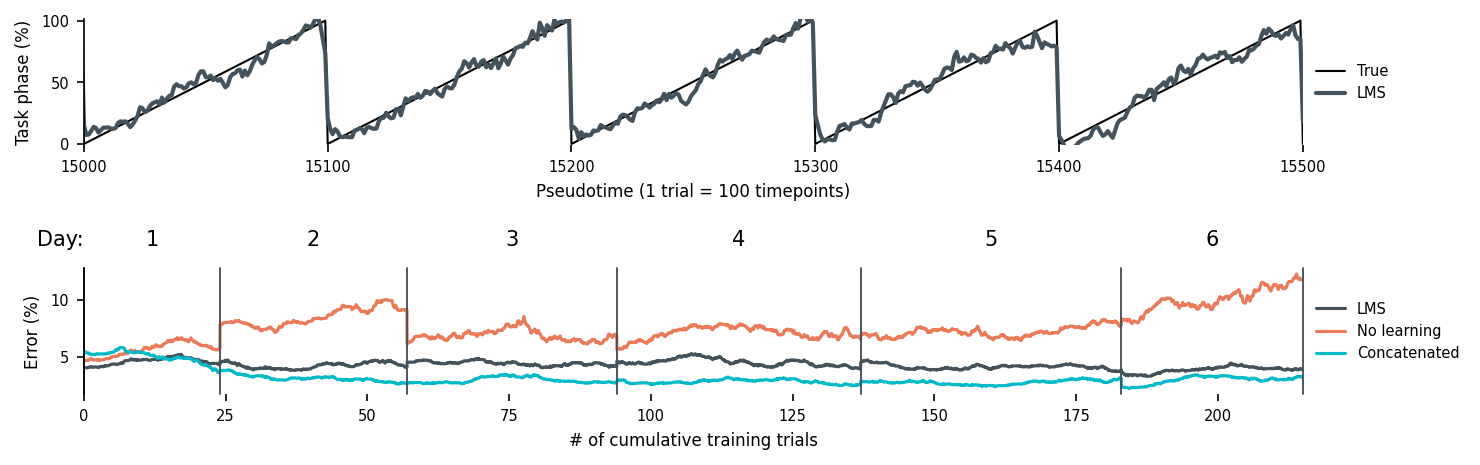

In [10]:
%matplotlib inline
from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color=[BLACK,RUST,TURQUOISE,OCHRE,AZURE])
matplotlib.rcParams['figure.dpi']=150

figure(figsize=(10,3.2))

subplot(211)
plot(100*(ols_trainx[Ntimes*ntrain:]*0.5+0.5),label='True',color='k',linestyle='-',lw=1)
plot(100*(h*0.5+0.5),label='LMS',color=BLACK,linestyle='-',lw=2)
simpleraxis()
t0 = 15000
t1 = t0 + 500
xlim(t0,t1)
xlabel('Pseudotime (1 trial = 100 timepoints)')
ylabel('Task phase (%)')
rightlegend()
ylim(-1,101)

subplot(212)
trialNo = arange(len(plot_e0))/Ntimes
plot(trialNo,0.5*100*plot_e ,label='LMS',color=BLACK)
plot(trialNo,0.5*100*plot_e0,label='No learning',color=RUST)
plot(trialNo,0.5*100*plot_ec,label='Concatenated',color=TURQUOISE)
simpleraxis()
ylabel('Error (%)')
rightlegend()
print('Getting weight change statistics')
samples_per_trial   = 100
trials_in_total     = len(x)
sessions_in_total   = MINDAYS
trials_per_session  = trials_in_total/sessions_in_total
samples_used_LMS    = len(testx)
trials_used_LMS     = trials_in_total - ntrain
sessions_used_LMS   = trials_used_LMS/trials_per_session
samples_per_session = samples_used_LMS / sessions_used_LMS
print('Testing data covers %f sessions'%sessions_used_LMS)
# Average %Δw / session
D = int(samples_per_session)
mabsd = mean(abs(w[D:,...]-w[:-D,...]))/mean(abs(w))*100
print('Mean %%Δweight over time corresponding to 1 session %0.2f'%mabsd)
for t in edges: 
    axvline(t/Ntimes,color=BLACK,lw=0.9,clip_on=0)
ytext = ylim()[0]+diff(ylim())*1.15
for s,middle in enumerate(0.5*(edges[1:]+edges[:-1])):
    text(middle/Ntimes,ytext,'%d'%(s+1),ha='center',va='bottom')
text(0,ytext,'Day:',ha='right',va='bottom')
xlabel('# of cumulative training trials')

tight_layout()

savefigure('manymouse_LMS_summary_8e-4_learning_rate_%d_days_%d_skip'%(MINDAYS,MAXSKIP),snap=False)

# Adjusting learning rate to give a target error level

This is done via binary search, and is very slow. 

In [11]:
def summarize_LMS_result(animal,sessions,result,verbose=True):
    '''
    Expects a `result` dictionary with the keys `w`, `ec`, `e`, `y`, and `e0`
    '''
    slens, edges           = get_session_lengths(animal,sessions,PRETRAIN)
    weights                = result['w']
    end_of_session_weights = weights[edges,:-1] #exclude constant weight
    inter_session_Δweights = diff(end_of_session_weights,axis=0)
    days                   = [daymap[animal,s] for s in sessions]
    Δdays                  = diff(days)[PRETRAIN-1:]
    Δweight_per_Δday       = inter_session_Δweights/Δdays[:,None]
    MABS_Δw_per_Δday       = mean(abs(Δweight_per_Δday))
    MABSW                  = mean(abs(weights))
    MABS_Δw_pct_per_day    = mean(MABS_Δw_per_Δday)/MABSW*100
    ec = mean(abs(result['ec']))
    er = mean(abs(result['e']))
    
    variance  = var(result['x'])
    residuals = var(result['e'])
    explained = variance-residuals
    pctΔvlms  = 100*explained/variance
    
    variance  = var(result['x'])
    residuals = var(result['ec'])
    explained = variance-residuals
    pctΔvcat  = 100*explained/variance
    
    variance  = var(result['x'])
    residuals = var(result['e0'])
    explained = variance-residuals
    pctΔvfix  = 100*explained/variance
    
    if not pctΔvcat>pctΔvfix:
        raise ValueError('Expected concat. performance to be better than no learning?')
    
    if abs(pctΔvlms-pctΔvfix)/pctΔvfix<1e-6:
        relperf = 0
    else:
        relperf = (pctΔvlms-pctΔvfix)/(pctΔvcat-pctΔvfix)*100
        
    if verbose:
        print('Mouse %s sessions %s'%(animal,sessions))
        print(' Average change is %0.2f%% per day'%MABS_Δw_pct_per_day)
        print(' Concatenated error level is %2f'%ec)
        print(' LMS          error level is %2f'%er)
        print(' %% explained variance %0.2f LMS'%pctΔvlms)
        print(' %% explained variance %0.2f Concat.'%pctΔvcat)
        print(' %% explained variance %0.2f Fixed'%pctΔvfix)
        print(' Relative performance %0.2f%%'%relperf)
    return relperf,MABS_Δw_pct_per_day

def get_plasticity_level_fixed_error(
                         units,
                         FIXED_ERROR,
                         minrate  = 1e-6,
                         maxrate  = 1e-2,
                         reg      = 1e-5,
                         PRETRAIN = 1,
                         NXVAL    = 10,
                         TOL      = 1e-3,
                         verbose  = False):
    
    # Predicting x from z
    # trainz = cat(z[:ntrain])
    # trainx = cat(x[:ntrain])
    # testz  = cat(z[ntrain:])
    # testx  = cat(x[ntrain:])

    # Identify target accuracy level: from concatenated performance
    wc,xc,_ = trial_crossvalidated_least_squares([zi[:,units] for zi in z[ntrain:]],x[ntrain:],NXVAL,shuffle=True)
    ec = testx - xc
    MABSEC = mean(abs(ec))

    # Identify initial weights and error without more learning:
    w0 = reglstsq(trainz[:,units],trainx)
    xh = (testz[:,units] @ w0).reshape(testx.shape)
    e0  = testx - xh
    MABSE0 = mean(abs(e0))

    def get_mabse_for_rate(rate):
        # Small subroutine
        try:
            w,e,xh = run_LMS(testz[:,units],testx,w0,rate=rate,reg=reg)
            return {
                'MABSE':mean(abs(e)),
                'x' :testx,
                'e0':e0,
                'ec':ec,
                'w' :w.squeeze(),
                'e' :e.squeeze(),
                'xh':xh.squeeze()}
        except FloatingPointError:
            # Return something unreasonably large
            #return mean(abs(Ytest))*10
            w  = np.repeat(w0,len(testx))
            xh = mean(testx)*np.ones(testx.shape)
            e  = xtest-xh
            return {
                'MABSE':np.nan,
                'x' :testx,
                'e0':e0,
                'ec':ec,
                'w' :w.squeeze(),
                'e' :e.squeeze(),
                'xh':xh.squeeze()}
    
    #Find fastest stable learning rate
    Σ = (testz[:,units].T @ testz[:,units])/ testx.shape[0]
    e,v = psd_eig(Σ)
    λmax = np.max(abs(e))
    λmaxrate = 2/λmax
    if maxrate>λmaxrate:
        warnings.warn('Max. learning rate is unstable')
    
    # Start with getting weight change at max/min learning rates
    performances = {}
    performances[minrate] = get_mabse_for_rate(minrate)['MABSE']
    performances[maxrate] = get_mabse_for_rate(maxrate)['MABSE']
    
    # Binary search to match target performance
    lower_rate = minrate
    upper_rate = maxrate
    while True:
        # Identify pivot
        perfs = [performances[lower_rate],performances[upper_rate]]
        rates = log(array([lower_rate,upper_rate])).ravel()
        if verbose:
            print(perfs)
            print(rates)
        if any(np.isnan(perfs)):
            rate = exp(mean(rates))
            warnings.warn('Undefined performance at one limit, using midpoint')
        else:
            if FIXED_ERROR<min(perfs):
                warnings.warn('Cannot achieve desired error level')
                return np.NaN,MABSE0,MABSEC,np.NaN,np.NaN,np.NaN
            if FIXED_ERROR>max(perfs):
                warnings.warn('Required error level is unrealistically large')
                return np.NaN,MABSE0,MABSEC,np.NaN,np.NaN,np.NaN
            rate  = exp(interp1d(perfs,rates)(FIXED_ERROR))
        # Test pivot
        result = get_mabse_for_rate(rate)
        MABSE = result['MABSE']
        performances[rate] = MABSE
        
        # Check convergence, update limits and iterate
        if MABSE>FIXED_ERROR and (MABSE-FIXED_ERROR)/FIXED_ERROR<TOL: break
        if MABSE>FIXED_ERROR: lower_rate = rate
        else:                 upper_rate = rate
        
    w = result['w']
    D = int(samples_per_session)
    MABSW = mean(abs(w))
    MABSD = mean(abs(w[D:,...]-w[:-D,...]))
    MABSP = MABSD/MABSW*100
        
    #Expects a `result` dictionary with the keys `w`, `ec`, `e`, `y`, and `e0`
    #rperf,MABS_Δw_pct_per_day=summarize_LMS_result(animal,sessions,result,verbose=False)
    # Get summary rate of weight change
    return MABSP,rate,MABSE0,MABSEC,MABSE,MABSW,MABSD

## Test search code

In [12]:
DO_TEST = False


units = arange(trainz.shape[1])

if DO_TEST:
    print(get_plasticity_level_fixed_error(
     units,
     0.1,
     minrate  = 1e-6,
     maxrate  = 1e-2,
     reg      = 1e-5,
     PRETRAIN = 1,
     NXVAL    = 10,
     verbose  = False))
    print('done')
else:
    print('Skipping search test')

Skipping search test


## Sample performance with subsets of neurons

In [13]:
Nnunits   = 25
Nreplicas = 50

# Define unit sets to check
Nneurons  = trainz.shape[1]-1
print('Testing subsets of %d neurons'%Nneurons)
Ntest     = array(sorted(list(set(int32(2**linspace(-2,0,Nnunits)*Nneurons)))))
unit_sets = []
for unit_number in Ntest[:-1]:
    for replica in range(Nreplicas):
        # Use random subset of neurons
        use_features = sorted(np.random.choice(arange(Nneurons),unit_number,replace=False))
        # always include the constant feature
        use_features = cat([use_features,[Nneurons]])
        unit_sets.append(use_features)
# Include set of all neurons once
unit_sets.append(arange(Nneurons+1))


Testing subsets of 1237 neurons


In [14]:
TARGET_ERROR = 0.1
MINRATE      = 1e-6
MAXRATE      = 0.5e-1
jobs         = unit_sets
print(len(jobs))

1201


# *STOP*

Do not run the next cell if you can avoid it. Instead skip to the following cell to load pre-computed results from "./datafiles/Δws_manymouse_saved.p" on disk (if it is available).

In [ ]:
def helper(p):
    i,p = p
    try:
        result = get_plasticity_level_fixed_error(*((p,)+(TARGET_ERROR,)))#,MINRATE,MAXRATE)))
        return i,result
    except FloatingPointError:
        warnings.warn('LMS numerical error')
        traceback.print_exc()
        return i,(np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN)

reset_pool()
print('Running sanity check..')
index = -5
units = jobs[index]
print(helper((0,units)))
Δws = parmap(helper,enumerate(jobs),debug=False)

Running sanity check..
(0, (12.173703981396997, 0.0008763944163064899, 0.18185870672539228, 0.06981557456949604, 0.10000000077775487, 0.02687679332847682, 0.0032719012595006252))


<ipython-input-11-079e41c468fb>:135: UserWarning: Cannot achieve desired error level
  warnings.warn('Cannot achieve desired error level')


[                                                  ]  1.7% 

<ipython-input-11-079e41c468fb>:135: UserWarning: Cannot achieve desired error level
  warnings.warn('Cannot achieve desired error level')
<ipython-input-11-079e41c468fb>:135: UserWarning: Cannot achieve desired error level
  warnings.warn('Cannot achieve desired error level')


[##############                                    ] 28.6% 

# Run notebook from here to use precomputed results

In [ ]:
saved = "./datafiles/Δws_manymouse_saved.p"

try:
    pickle.dump(Δws,open(saved,'wb'))
except:
    print('Δws variable not yet initialized')
    try:
        Δws = pickle.load(open(saved,'rb'))
        print('Loaded from disk')
    except:
        print('Failed to load Δws from disk')

In [ ]:
from  neurotools.graphics.plot import more_yticks

counts = defaultdict(list)
for u,Δw in zip(jobs,Δws):
    if len(Δw)==7:
        counts[len(u)].append(array(Δw))
for k in counts.keys():
    counts[k] = array(counts[k])
n     = sorted(list(counts.keys()))
μ     = array([nanmean(counts[k],axis=0) for k in n]).T
σ     = array([ nanstd(counts[k],axis=0) for k in n]).T

# MABSP,rate,MABSE0,MABSEC,MABSE,MABSW,MABSD
figure(figsize=(10,2))
alpha = 0.25
subplot(131)
c = AZURE
i = 5
fill_between(n,μ[i]-1.96*σ[i],μ[i]+1.96*σ[i],alpha=alpha,color=c,lw=0)
plot(n,μ[i],color=c)
simpleraxis()
ylabel('Average |w|')
xlabel('# Neurons')
xlim(Nneurons//4,Nneurons)
more_yticks()

subplot(132)
c = RUST
i = 6
fill_between(n,μ[i]-1.96*σ[i],μ[i]+1.96*σ[i],alpha=alpha,color=c,lw=0)
plot(n,μ[i],color=c)
simpleraxis()
ylabel('Average |Δw|/day')
xlabel('# Neurons')
xlim(Nneurons//4,Nneurons)
more_yticks()
subplot(133)
c = TURQUOISE
fill_between(n,μ[0]-1.96*σ[0],μ[0]+1.96*σ[0],alpha=alpha,color=c,lw=0)
plot(n,μ[0],color=c)
simpleraxis()
ylabel('%Δw/day')
xlabel('# Neurons')
text(xlim()[1],ylim()[1]+pixels_to_yunits(5),'Shaded = inner 95%',
    ha='right',
    va='top')
xlim(Nneurons//4,Nneurons)

tight_layout()
savefigure('LMS_manymouse_weight_change_population_size_%d_days_%d_skip'%(MINDAYS,MAXSKIP),snap=False)